In [2]:
import sys
import rdkit
from argparse import ArgumentParser
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import QED
import os
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from rdkit.Chem import MACCSkeys
from sklearn.manifold import TSNE
import numpy as np

# T-SNE

In [3]:
def mscatter(x, y,  ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    
    if not ax: ax = plt.gca()
    sc = ax.scatter(x, y, **kw)

    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
                
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)

    return sc

def plot_embedding_2d(X, labels, title=None, fname='None'):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    # num_of_labels = labels.max().item() + 1

    plt.figure(figsize=(16,10))
    # ax = plt.subplot(111)

    # colors_space = np.linspace(0, 1, num_of_labels)           # 生成颜色空间
    # label_to_color = {}                                 # 将标签对应为颜色
    # for i in range(num_of_labels):
    #     label_to_color[i] = colors_space[i]

    colors = []
    for label in labels:
        colors.append(label)

    sc = plt.scatter(X[:, 0], X[:, 1], c=colors, s=20)
    # scatter = mscatter(X[:, 0], X[:, 1], c='r', ax=ax)

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    # plt.colorbar(sc)

    plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [4]:
def getFP(fname, marker = 0):
    # df = pd.read_csv('./data/drd2_active.csv')  
    df = pd.read_csv(fname)         
    smiles_list = df['smiles'].values
    smiles_list = list(set(smiles_list))

    MorganFP = []
    for smiles in smiles_list:
        m = Chem.MolFromSmiles(smiles)
        # fp = AllChem.GetMorganFingerprintAsBitVect(m, 3, 2048).ToList()
        fp = AllChem.GetMorganFingerprintAsBitVect(m, 3, 2048)
        MorganFP.append(fp)

    # MorganFP = np.array(MorganFP)
    labels = [marker for i in range(len(MorganFP))]
    labels = np.array(labels)

    return smiles_list,MorganFP, labels

In [5]:
def getFP_by_data(smiles_list, marker = 0):
    # df = pd.read_csv('./data/drd2_active.csv')  
    # smiles_list = list(set(smiles_list))

    MorganFP = []
    for smiles in smiles_list:
        m = Chem.MolFromSmiles(smiles)
        # fp = AllChem.GetMorganFingerprintAsBitVect(m, 3, 2048).ToList()
        fp = AllChem.GetMorganFingerprintAsBitVect(m, 3, 2048)
        MorganFP.append(fp)

    # MorganFP = np.array(MorganFP)
    labels = [marker for i in range(len(MorganFP))]
    labels = np.array(labels)

    return smiles_list,MorganFP, labels

In [6]:
def get_list_fps(fps):
    fps_list = []
    for fp in fps:
        fps_list.append(fp.ToList())
    fps_list = np.array(fps_list)
    return fps_list

# 训练集数据

In [20]:
# true_fname = '../data/train/bbb_qed.csv'
true_fname = '../data/train/hia_qed.csv'
true_smiles, true_fps, true_labels = getFP(true_fname, 'grey')

In [22]:
true_fname = '../data/train/hia_qed.csv'
df_true = pd.read_csv(true_fname) 
train_smiles = []
for smiles in df_true['smiles'].values:
    try:
        m = Chem.MolFromSmiles(smiles)
    except Exception as e:
        continue

    if m is None:
        continue

    qed=QED.qed(m)
    sas = sascorer.calculateScore(m)
    if qed < 0.6 or sas < 0.67:
            continue
    
    train_smiles.append(smiles)
    
train_smiles, true_fps, true_labels = getFP_by_data(train_smiles, 'grey')

In [23]:
len(train_smiles)

2481

Computing t-SNE embedding
(2481, 2)


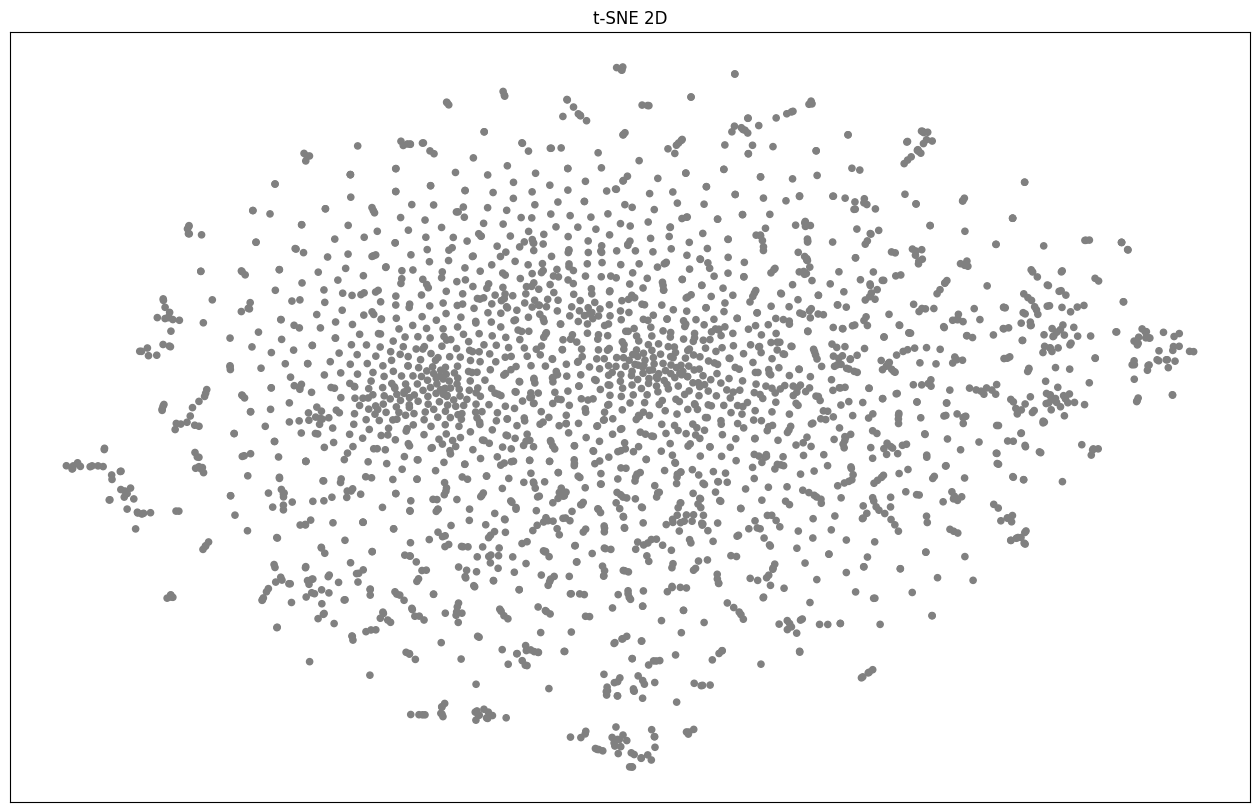

In [24]:
true_fps_list = get_list_fps(true_fps)
print("Computing t-SNE embedding")
tsne2d = TSNE(n_components=2, init='pca', random_state=0)

X_tsne_2d = tsne2d.fit_transform(true_fps_list)
print(X_tsne_2d.shape)
plot_embedding_2d(X_tsne_2d, true_labels, title = "t-SNE 2D")

# 生成的数据

In [25]:
score_file = '../log/hia_qed_sa.txt'
score_df = pd.read_csv(score_file, sep=' ')
scores = score_df['1'].values

In [26]:
pred_mols = []
pred_smiles = []

# fname = '../log/eval_gtp2_292772_f_bbb_qed_sa_150.log'
fname = '../log/eval_gtp2_292772_f_hia_qed_sa_150.log'
# fname = '../log/eval_gtp2_292772_f_pgps_qed_sa_150.log'
f =  open(fname,'r')
lines = f.readlines()
predicts = []
for line in lines:
    if 'startofsmiles' in line:
        tmp = line.split('<|startofsmiles|>')
        predicts.append(tmp[-1].strip())

nums = len(predicts)
for i in range(nums):
    smiles = predicts[i]

    try:
        m = Chem.MolFromSmiles(smiles)
    except Exception as e:
        continue

    if m is None:
        continue

    qed=QED.qed(m)
    sas = sascorer.calculateScore(m)
    if qed < 0.6 or sas < 0.67:
            continue

    pred_mols.append(m)
    pred_smiles.append(smiles)

[11:49:00] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 18 21 22
[11:49:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20


In [27]:
pred_smiles, pred_fps, pred_labels = getFP_by_data(pred_smiles, 'C1')

Computing t-SNE embedding
(6813, 2)


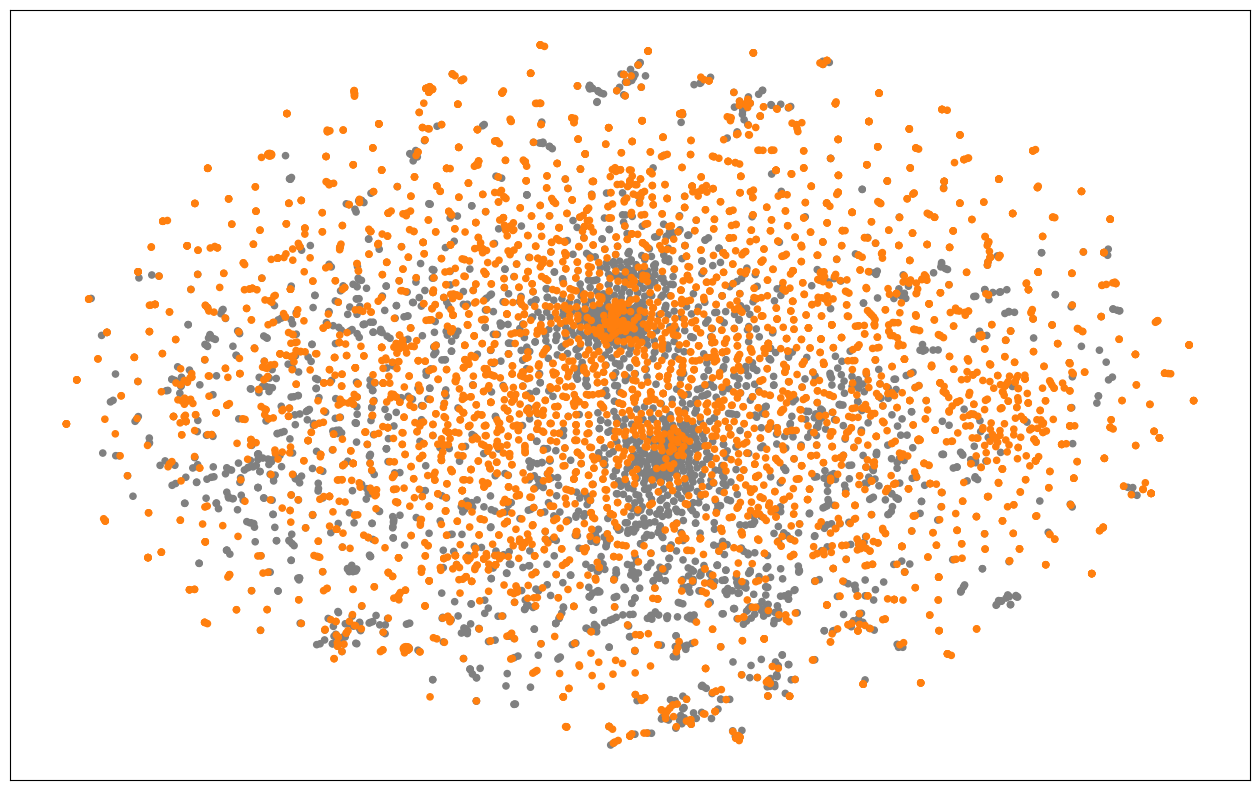

In [28]:
pred_fps_list = get_list_fps(pred_fps)

x = np.concatenate([true_fps_list,pred_fps_list])
y = np.concatenate([true_labels,pred_labels])

print("Computing t-SNE embedding")
tsne2d = TSNE(n_components=2, init='pca', random_state=0)

X_tsne_2d = tsne2d.fit_transform(x)
print(X_tsne_2d.shape)
plot_embedding_2d(X_tsne_2d, y, fname='../fig/tsne_HIA_QED_SA.svg')

In [14]:
print(len(scores),len(pred_smiles))

4332 4332


In [16]:
true_smiles = train_smiles
pred_mols_hits = []
non_novel = []
for i in range(len(scores)):
    score = scores[i]
    smiles = pred_smiles[i]
    mol = pred_mols[i]

    if smiles in true_smiles:
        non_novel.append(smiles)
        # continue

    if score > 0.6:
        pred_mols_hits.append(mol)
print("Number of non novel: ", len(non_novel))

Number of non novel:  305


In [17]:
fraction_similar = 0

sim_distribution = []
for i in range(len(pred_fps)):
    sims = DataStructs.BulkTanimotoSimilarity(pred_fps[i], true_fps)

    if max(sims) >= 0.4:
        fraction_similar += 1
    sim_distribution.append(max(sims))

print('novelty:', 1 - fraction_similar / len(pred_mols))

novelty: 0.7873961218836565


In [18]:
novel = 0
for smiles in pred_smiles:
    if smiles not in true_smiles:
        novel = novel + 1
print('novelty:', novel / len(pred_mols))

novelty: 0.9295937211449676


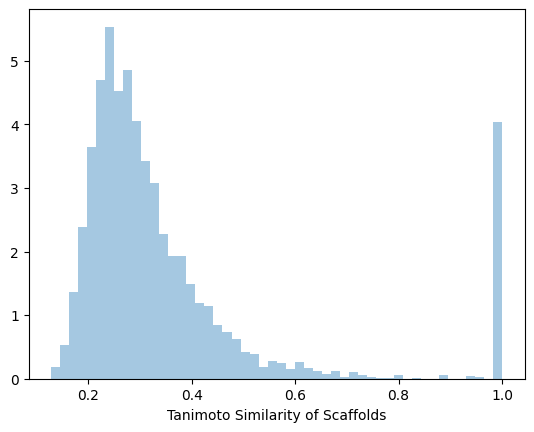

In [19]:
n, bins, patches = plt.hist(sim_distribution, 50, density=True, alpha=0.4)
plt.xlabel('Tanimoto Similarity of Scaffolds')
plt.savefig(f'../fig/tani_HIA_QED_SA.svg', bbox_inches='tight')